```
/project-folder/
│
├── main.ipynb               <-- notebook utama
├── preprocessing.py         <-- data loader & encoder
├── trainer.py               <-- training model RF & XGB
├── evaluation.py            <-- evaluasi & stacking
└── plotting.py              <-- fungsi visualisasi

```





Bening Pastika (103052300097),

In [ ]:
%%writefile preprocessing.py
"""Preprocessing module for house price prediction."""

from pathlib import Path
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class HousePricePreprocessor:
    """Class for loading, processing, and encoding house price dataset."""

    def __init__(self, csv_path, cache_path="preprocessed_data.joblib", scaler_path="scaler.joblib"):
        self.csv_path = csv_path
        self.cache_path = cache_path
        self.scaler_path = scaler_path

        self.x_encoded = None
        self.y = None
        self.data = None
        self.scaler = None

    def file_exists(self):
        return Path(self.cache_path).is_file() and Path(self.scaler_path).is_file()

    def load_or_process_data(self):
        """
        Load data from cache or process raw CSV data if cache doesn't exist.
        """
        if self.file_exists():
            print("🔁 Loading preprocessed data from cache...")
            self.x_encoded, self.y = joblib.load(self.cache_path)
            self.scaler = joblib.load(self.scaler_path)
            self._read_csv()
        else:
            self._read_csv()
            self._filter_outliers()
            self._prepare_data()
            joblib.dump((self.x_encoded, self.y), self.cache_path)
            joblib.dump(self.scaler, self.scaler_path)

        print("📄 Preview Dataset:")
        print(self.data.head())

    def _read_csv(self):
        self.data = pd.read_csv(self.csv_path)

    def _filter_outliers(self):
        """
        Optional: Drop extreme outliers (top 1%) based on LuasTanah, LuasBangunan, Harga
        """
        for col in ["LuasTanah", "LuasBangunan", "Harga"]:
            q = self.data[col].quantile(0.99)
            self.data = self.data[self.data[col] <= q]

    def _prepare_data(self):
        features = ["LuasTanah", "LuasBangunan", "JumlahKamarTidur", "JumlahKamarMandi"]
        X = self.data[features]

        self.scaler = StandardScaler()
        X_scaled = pd.DataFrame(self.scaler.fit_transform(X), columns=features)

        harga = self.data["Harga"]
        if (harga <= 0).any():
            raise ValueError("Terdapat nilai 'Harga' yang kurang dari atau sama dengan nol.")

        self.x_encoded = X_scaled
        self.y = np.log1p(harga)

    def split_data(self, test_size=0.2, random_state=42):
        return train_test_split(self.x_encoded, self.y, test_size=test_size, random_state=random_state)

    def explore_data(self):
        if self.data is not None:
            print("📊 Info Dataset:")
            print(self.data.info())
            print("\n📈 Statistik Deskriptif:")
            print(self.data.describe())
            print("\n🧪 Cek Missing Values:")
            print(self.data.isnull().sum())
        else:
            print("❗ Data belum dimuat. Jalankan load_or_process_data() terlebih dahulu.")


Overwriting preprocessing.py


Lu’luil Maknun Ardiansyah (103052300071),

In [ ]:
%%writefile trainer.py
"""Trainer module for training RF and XGBoost models with optional retrain and caching."""

import os
import joblib
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


class ModelTrainer:
    """
    A class to train and cache Random Forest and XGBoost regression models.
    """

    def __init__(self, model_cache_dir="cache"):
        """
        Initialize the trainer and create cache directory if it doesn't exist.
        """
        self.model_cache_dir = model_cache_dir
        os.makedirs(self.model_cache_dir, exist_ok=True)

    def get_model_path(self, model_type):
        return os.path.join(self.model_cache_dir, f"{model_type}_model.joblib")

    def train_model(self, model_type, x_train, y_train, force_retrain=False):
        """
        Train or load the selected model.

        Args:
            model_type (str): 'rf' or 'xgb'
            x_train, y_train: training data
            force_retrain (bool): if True, ignore cache and retrain model

        Returns:
            Trained model
        """
        path = self.get_model_path(model_type)
        if os.path.exists(path) and not force_retrain:
            print(f"🔁 Loading cached {model_type.upper()} model...")
            return joblib.load(path)

        if model_type == "rf":
            model = RandomForestRegressor(
                n_estimators=200,
                max_depth=None,
                min_samples_split=2,
                min_samples_leaf=1,
                random_state=42,
                n_jobs=-1
            )
        elif model_type == "xgb":
            model = XGBRegressor(
                n_estimators=200,
                max_depth=6,
                learning_rate=0.1,
                gamma=0,
                reg_lambda=1,
                subsample=1.0,
                random_state=42,
                n_jobs=-1
            )
        else:
            raise ValueError(f"Model '{model_type}' tidak dikenali. Gunakan 'rf' atau 'xgb'.")

        print(f"🛠 Training {model_type.upper()} model...")
        model.fit(x_train, y_train)

        print("📌 Fitur saat training:", model.feature_names_in_)
        joblib.dump(model, path)
        return model


Overwriting trainer.py


Reggidya Elsa Serena Situmorang (103052330019),

In [ ]:
%%writefile evaluation.py
"""Evaluation module for house price prediction models."""

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

META_COLUMNS = ["rf_prediction", "xgb_prediction"]


def preprocess_numerical(df):
    """
    Select only numerical columns and fill missing values with 0.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Preprocessed numerical DataFrame.
    """
    return df.select_dtypes(include=["number"]).fillna(0)


def evaluate_model(model, x_train, y_train, x_test, y_test):
    """
    Evaluasi model dalam skala log dan skala asli, dengan proteksi overflow.
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print("=== Evaluasi dalam skala log ===")
    print("Train RMSE:", mean_squared_error(y_train, y_train_pred) ** 0.5)
    print("Test RMSE:", mean_squared_error(y_test, y_test_pred) ** 0.5)
    print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
    print("Test MAE:", mean_absolute_error(y_test, y_test_pred))
    print("Train R2:", r2_score(y_train, y_train_pred))
    print("Test R2:", r2_score(y_test, y_test_pred))

    print("\n=== Evaluasi dalam skala asli (expm1) ===")

    MAX_LOG = 20

    # CLIP semua sebelum expm1!
    y_train_pred_clipped = np.clip(y_train_pred, 0, MAX_LOG)
    y_test_pred_clipped = np.clip(y_test_pred, 0, MAX_LOG)

    # Transform kembali target asli dan prediksi ke skala rupiah
    y_train_orig = np.expm1(np.clip(y_train, 0, MAX_LOG))
    y_test_orig = np.expm1(np.clip(y_test, 0, MAX_LOG))
    y_train_pred_orig = np.expm1(y_train_pred_clipped)
    y_test_pred_orig = np.expm1(y_test_pred_clipped)

    # Evaluasi hasilnya
    print("Train RMSE:", mean_squared_error(y_train_orig, y_train_pred_orig) ** 0.5)
    print("Test RMSE:", mean_squared_error(y_test_orig, y_test_pred_orig) ** 0.5)
    print("Train MAE:", mean_absolute_error(y_train_orig, y_train_pred_orig))
    print("Test MAE:", mean_absolute_error(y_test_orig, y_test_pred_orig))
    print("Train R2:", r2_score(y_train_orig, y_train_pred_orig))
    print("Test R2:", r2_score(y_test_orig, y_test_pred_orig))



def generate_meta_features(rf_model, xgb_model, x_train, x_test):
    """
    Generate meta features from RF and XGB predictions for stacking.

    Args:
        rf_model: Trained Random Forest model.
        xgb_model: Trained XGBoost model.
        x_train (pd.DataFrame): Training features.
        x_test (pd.DataFrame): Test features.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Meta features for train and test sets.
    """
    x_train_meta = pd.DataFrame({
        META_COLUMNS[0]: rf_model.predict(x_train),
        META_COLUMNS[1]: xgb_model.predict(x_train),
    })

    x_test_meta = pd.DataFrame({
        META_COLUMNS[0]: rf_model.predict(x_test),
        META_COLUMNS[1]: xgb_model.predict(x_test),
    })

    return x_train_meta, x_test_meta


Overwriting evaluation.py


Reggidya Elsa Serena Situmorang (103052330019),

In [ ]:
%%writefile predictor.py
"""Prediction interface for house price using stacked model (RF + XGB + Meta)."""

import pandas as pd
import numpy as np
import joblib
from evaluation import META_COLUMNS


def predict_from_user_input(rf_model, xgb_model, meta_model, feature_columns, scaler_path="scaler.joblib"):
    """
    Terima input user, lakukan preprocessing dan scaling, lalu prediksi harga rumah.

    Args:
        rf_model: Trained Random Forest model
        xgb_model: Trained XGBoost model
        meta_model: Stacking model (RandomForest or lainnya)
        feature_columns (list): List of expected feature columns
        scaler_path (str): Path ke file scaler yang disimpan saat preprocessing
    """
    print("Masukkan data rumah yang ingin diprediksi:")
    try:
        luas_tanah = float(input("Luas Tanah (m2): "))
        luas_bangunan = float(input("Luas Bangunan (m2): "))
        jumlah_kamar_tidur = int(input("Jumlah Kamar Tidur: "))
        jumlah_kamar_mandi = int(input("Jumlah Kamar Mandi: "))
    except ValueError:
        print("❌ Input tidak valid. Harus berupa angka.")
        return

    input_df = pd.DataFrame([{
        "LuasTanah": luas_tanah,
        "LuasBangunan": luas_bangunan,
        "JumlahKamarTidur": jumlah_kamar_tidur,
        "JumlahKamarMandi": jumlah_kamar_mandi,
    }])

    # Load scaler
    try:
        scaler = joblib.load(scaler_path)
    except FileNotFoundError:
        print("❌ File scaler tidak ditemukan. Pastikan 'scaler.joblib' sudah dibuat saat preprocessing.")
        return

    # Scaling
    input_scaled = pd.DataFrame(
        scaler.transform(input_df),
        columns=input_df.columns
    )

    # Prediksi dari masing-masing model
    rf_pred = rf_model.predict(input_scaled)
    xgb_pred = xgb_model.predict(input_scaled)

    # Gabungkan ke input meta
    meta_input = pd.DataFrame({
        META_COLUMNS[0]: rf_pred,
        META_COLUMNS[1]: xgb_pred
    })

    # Prediksi akhir (log)
    log_pred = meta_model.predict(meta_input)
    print(f"📊 Prediksi (log-scale): {log_pred[0]:.4f}")

    # Transformasi balik ke skala rupiah
    final_pred = np.expm1(log_pred)[0]

    if final_pred > 1e9:
        print(f"🎯 Prediksi Harga Rumah: Rp {final_pred:,.0f} (sekitar Rp {final_pred / 1e9:.2f} miliar)")
    else:
        print(f"🎯 Prediksi Harga Rumah: Rp {final_pred:,.0f}")


Writing predictor.py


Lu’luil Maknun Ardiansyah (103052300071),

In [ ]:
%%writefile plotting.py
import matplotlib.pyplot as plt
import seaborn as sns

def plot_price_distribution(data):
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x="Harga", kde=True, color='g', edgecolor="black", linewidth=1.2)
    plt.title("Distribusi Harga Rumah")
    plt.show()

def plot_pairplot(data):
    sns.pairplot(data)


Overwriting plotting.py


main.py

Bening Pastika (103052300097),

In [ ]:
try:
    file_name  # Cek apakah sudah ada sebelumnya
except NameError:
    try:
        # Untuk Google Colab
        from google.colab import files
        print("📁 Silakan upload file CSV kamu...")
        uploaded = files.upload()
        file_name = list(uploaded.keys())[0]
    except Exception as e:
        print("⚠️ Gagal upload via Colab, coba input manual.")
        file_name = input("Masukkan nama file CSV (dengan ekstensi): ")

print(f"✅ File yang digunakan: {file_name}")

✅ File yang digunakan: HARGA RUMAH JAKSEL_clean (3).csv


🔁 Loading preprocessed data from cache...
📄 Preview Dataset:
          Harga  LuasTanah  LuasBangunan  JumlahKamarTidur  JumlahKamarMandi  \
0  2.800000e+10       1100           700                 5                 6   
1  1.900000e+10        824           800                 4                 4   
2  4.700000e+09        500           400                 4                 3   
3  4.900000e+09        251           300                 5                 4   
4  2.800000e+10       1340           575                 4                 5   

  Garasi    Kota  
0    ADA  JAKSEL  
1    ADA  JAKSEL  
2    ADA  JAKSEL  
3    ADA  JAKSEL  
4    ADA  JAKSEL  
📊 Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Harga             1000 non-null   float64
 1   LuasTanah         1000 non-null   int64  
 2   LuasBangunan      1000 non-nul

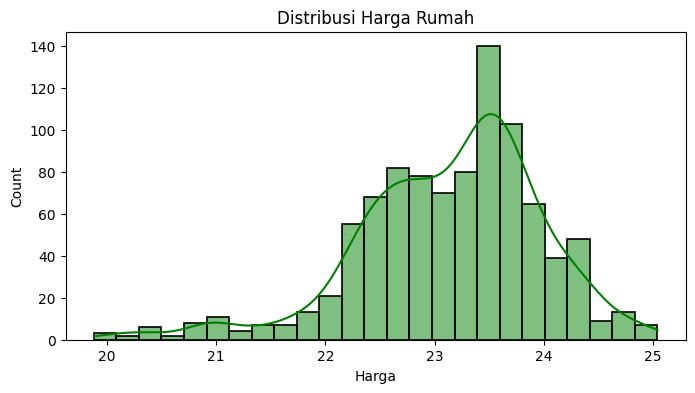

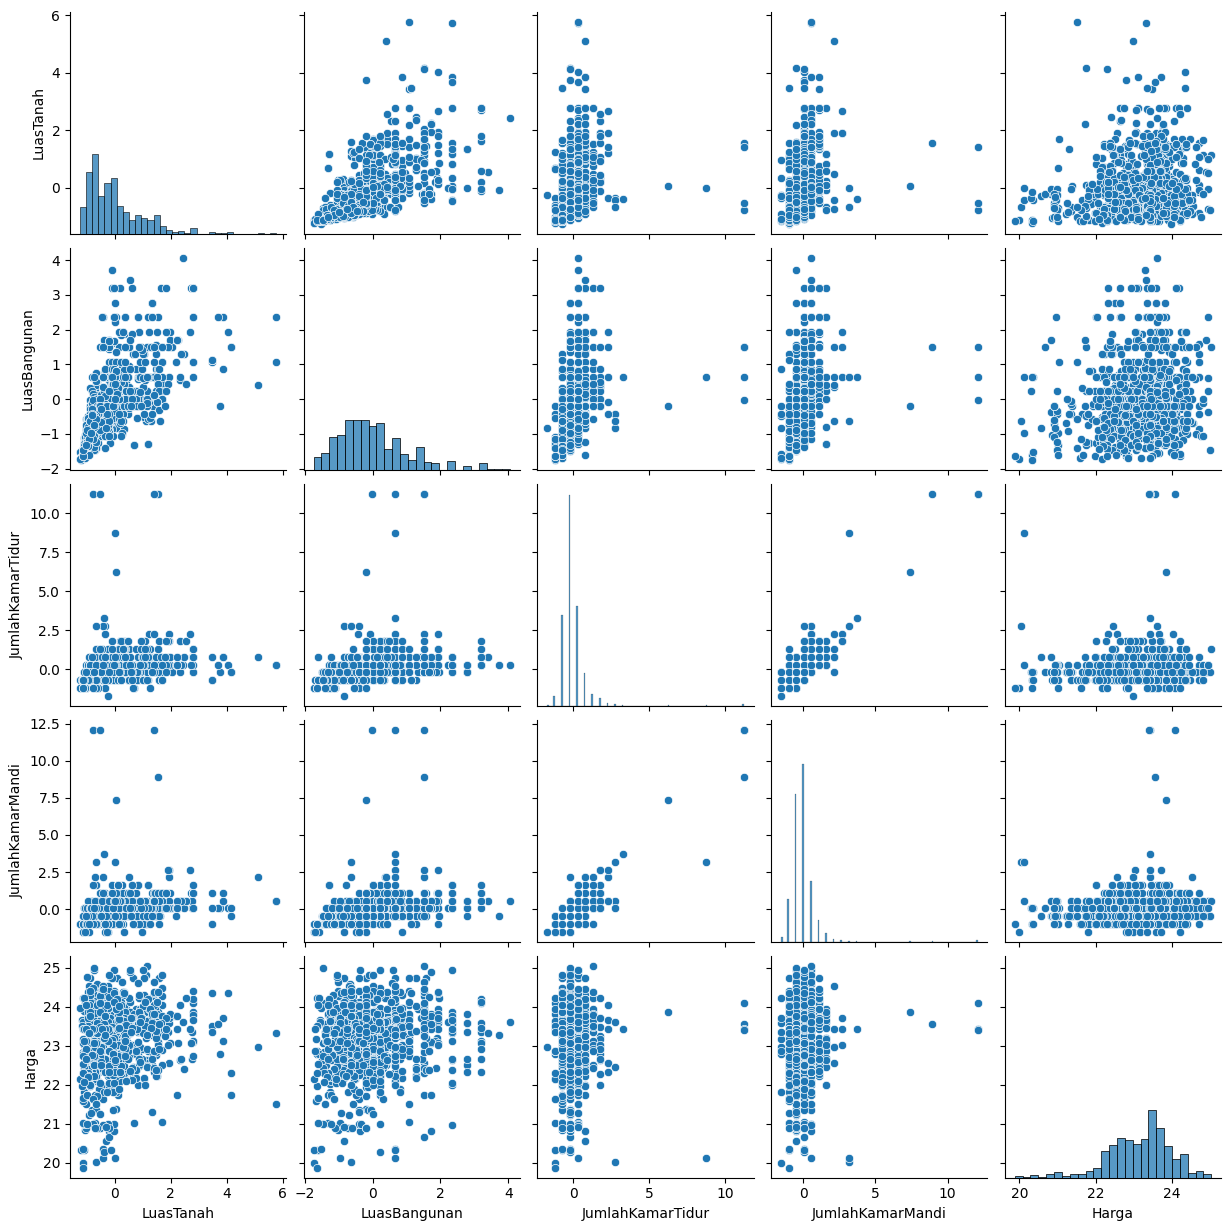

In [ ]:
from preprocessing import HousePricePreprocessor
from trainer import ModelTrainer
from evaluation import preprocess_numerical, evaluate_model, generate_meta_features
from sklearn.ensemble import RandomForestRegressor
from plotting import plot_price_distribution, plot_pairplot

# Preprocessing
processor = HousePricePreprocessor(file_name)
processor.load_or_process_data()
processor.explore_data()
df_preview = processor.x_encoded.copy()
print(df_preview.head())
X_train, X_test, y_train, y_test = processor.split_data()
X_train = preprocess_numerical(X_train)
X_test = preprocess_numerical(X_test)

# Setelah preprocessing
plot_price_distribution(processor.x_encoded.join(processor.y))  # atau
plot_pairplot( processor.x_encoded.join(processor.y))


In [ ]:
import shutil, os
from trainer import ModelTrainer
from evaluation import evaluate_model, generate_meta_features
from sklearn.linear_model import RidgeCV

# Hapus cache agar model benar-benar dilatih ulang
if os.path.exists("cache"):
    shutil.rmtree("cache")

# Inisialisasi trainer
trainer = ModelTrainer()

# Train RF dan XGB dengan paksa retrain
rf_model = trainer.train_model("rf", x_train, y_train, force_retrain=True)
xgb_model = trainer.train_model("xgb", x_train, y_train, force_retrain=True)

# Filter kolom agar cocok dengan fitur training
x_train = x_train[rf_model.feature_names_in_]
x_test = x_test[rf_model.feature_names_in_]

# Buat meta features dari prediksi RF dan XGB
x_train_meta, x_test_meta = generate_meta_features(rf_model, xgb_model, x_train, x_test)

# Latih meta model RidgeCV
meta_model = RidgeCV()
meta_model.fit(x_train_meta, y_train)

# Evaluasi meta model (yang dipakai = meta_model, bukan rf_model)
evaluate_model(meta_model, x_train_meta, y_train, x_test_meta, y_test)


🛠 Training RF model...
📌 Fitur saat training: ['LuasTanah' 'LuasBangunan' 'JumlahKamarTidur' 'JumlahKamarMandi']
🛠 Training XGB model...
📌 Fitur saat training: ['LuasTanah' 'LuasBangunan' 'JumlahKamarTidur' 'JumlahKamarMandi']
=== Evaluasi dalam skala log ===
Train RMSE: 0.12262061335386634
Test RMSE: 0.3880268776826822
Train MAE: 0.0841932601533754
Test MAE: 0.2774264047272892
Train R2: 0.979272397131598
Test R2: 0.7975483490515927

=== Evaluasi dalam skala asli (expm1) ===
Train RMSE: 1567472.445482797
Test RMSE: 0.0
Train MAE: 66746.82320932997
Test MAE: 0.0
Train R2: 0.37797977556038254
Test R2: 1.0


In [ ]:
from predictor import predict_from_user_input
predict_from_user_input(rf_model, xgb_model, meta_model, x_train.columns)


Masukkan data rumah yang ingin diprediksi:
Luas Tanah (m2): 1248
Luas Bangunan (m2): 1000
Jumlah Kamar Tidur: 9
Jumlah Kamar Mandi: 8
📊 Prediksi (log-scale): 24.6600
🎯 Prediksi Harga Rumah: Rp 51,251,094,733 (sekitar Rp 51.25 miliar)
